### An Exploration of the "inverse problem" with PINNs
This is finding the parameters

##Import necessary 

In [1]:
import tensorflow as tf
from tensorflow.python.ops import math_ops
import keras.backend as K
import numpy as np

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math



2024-01-24 13:49:10.838678: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-24 13:49:11.045376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 13:49:11.045413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 13:49:11.081475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 13:49:11.155083: I tensorflow/core/platform/cpu_feature_guar

In [7]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y  = exp*2*A*cos
    return y


(500,) (500,)
(10,) (10,)


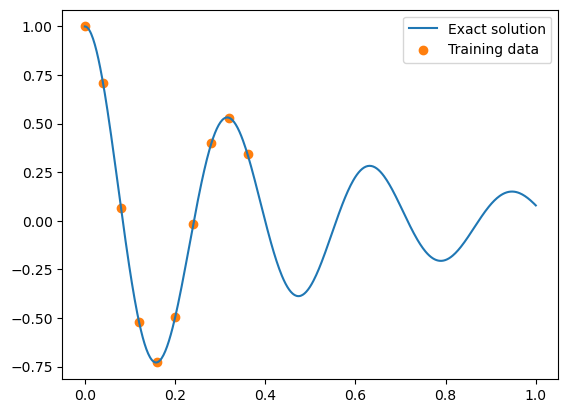

In [9]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = np.linspace(0,1,500)
y = oscillator(d, w0, x)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [2]:

# Hyperparameters
batch_size = 1
epochs = 1000
mu_lr = 0.001  # rlc learning rate
optimizer = Adam(learning_rate=0.001)
weight_init = RandomNormal()


In [ ]:

# Build model
inputs = tf.keras.Input(shape=(1,))
x = layers.Dense(128, activation='gelu', kernel_initializer=weight_init,
                 kernel_regularizer=None)(inputs)
x = layers.Dense(128, activation='gelu', kernel_initializer=weight_init,
                 kernel_regularizer=None)(x)
output = layers.Dense(1, activation='linear', kernel_initializer=weight_init)(x)
model = tf.keras.Model(inputs, output)



In [ ]:

x_physics = tf.linspace(0,1,30) # sample locations over the problem domain
#mu, k = 2*d, w0**2
k = w0**2

# additional variables added to  gradient tracking
mu = tf.Variable([0.1], trainable=True)

# Step function
def step(t_coloc, i_coloc, t_init, i_init, t_init2, v_init2, rlc_lr):

    t_coloc = tf.convert_to_tensor(t_coloc)
    t_coloc = tf.reshape(t_coloc, [batch_size, 1])
    t_coloc = tf.Variable(t_coloc, name='t_coloc')
    with tf.GradientTape(persistent=True) as tape:

        # model_loss1: initial condition i_init @ t_init -> f(t) initial condition
        pred_init = model(t_init)
        model_loss1 = math_ops.squared_difference(pred_init, i_init)

        # model_loss3: initial condition v_init2 @ t_init2 -> f'(t) initial condition
        t_init2 = tf.convert_to_tensor(t_init2)
        t_init2 = tf.reshape(t_init2, [1, 1])
        t_init2 = tf.Variable(t_init2, name='t_init2')
        pred_init2 = model(t_init2)
        dfdx = tape.gradient(pred_init2, t_init2)  # f'(t)
        vl = dfdx * tf.cast(L, tf.float64)  # inductor voltage due to dfdx
        model_loss3 = math_ops.squared_difference(vl, v_init2)
        model_loss3 = tf.cast(model_loss3, tf.float32)

        # 1st and 2nd order gradients for co-location pts
        with tf.GradientTape(persistent=True) as tape2:
            pred_y = model(t_coloc)
            dfdx = tape2.gradient(pred_y, t_coloc)  # f'(t)
        dfdx2 = tape2.gradient(dfdx, t_coloc)  # f"(t)

        # model_loss2: collocation points
        pred_y = tf.cast(pred_y, tf.float64)
        R64 = tf.cast(R, tf.float64)
        L64 = tf.cast(L, tf.float64)
        C64 = tf.cast(C, tf.float64)
        residual = dfdx2 + (R64 / L64) * dfdx + pred_y / (L64 * C64
        model_loss2 = K.mean(math_ops.square(residual), axis=-1)
        model_loss2 = tf.cast(model_loss2, tf.float32)

        # model_loss4: response
        pred_response = model(t_coloc)
        model_loss4 = K.mean(math_ops.squared_difference(pred_response, i_coloc), axis=-1)

        #total loss
        model_loss = model_loss1 + model_loss2 + model_loss3 + model_loss4 * 10

        trainable = model.trainable_variables
        trainable.append(R)
        trainable.append(L)
        trainable.append(C)
        model_gradients = tape.gradient(model_loss, trainable)

        # Update model
        optimizer.apply_gradients(zip(model_gradients, trainable))
        R.assign_sub(model_gradients[6] * rlc_lr)
        L.assign_sub(model_gradients[7] * rlc_lr)
        C.assign_sub(model_gradients[8] * rlc_lr)

    return R, L, C, model_loss


##### optional for progress plots  ##########
# progress plot array initialization
epoch_plt = np.zeros(epochs) 
loss_plt = np.zeros(epochs)
r_plot = np.zeros(epochs)
l_plot = np.zeros(epochs)
for epoch in range(epochs):
    epoch_plt[epoch] = epoch
#############################################


bat_per_epoch = math.floor(len(t_coloc) / batch_size)

#  Training loop
for epoch in range(epochs):

    for j in range(bat_per_epoch):
        n = j * batch_size
        R, L, C, loss = step(t_coloc[n:n + batch_size], i_coloc[n:n + batch_size],
                             t_init, i_init, t_init2, v_init2, rlc_lr)


    # optional for progress plots  ##########
    # model_loss, R, L and C plot data
    r_plot[epoch] = R.numpy()
    l_plot[epoch] = L.numpy()
    c_plot[epoch] = C.numpy()
    loss_plt[epoch] = loss

    if (epoch % 20) == 0:  # plot every 20 epochs
        print(f'epoch: {epoch}   loss: {loss}   R: {R.numpy()}   L: {L.numpy()}   C: {C.numpy()}')

        # model_loss and R plot
        plt.figure()
        fig, axs = plt.subplots(2, 1)

        axs[0].plot(epoch_plt[0:(epochs - 1)], loss_plt[0:(epochs - 1)])
        axs[0].set_xlim([0, epochs])
        axs[0].set_yscale('log')
        axs[0].set_ylim(top=1.0)

        axs[1].plot(epoch_plt[0:(epochs - 1)], r_plot[0:(epochs - 1)], 'r',
                    epoch_plt[0:(epochs - 1)], l_plot[0:(epochs - 1)], 'g',
                    epoch_plt[0:(epochs - 1)], c_plot[0:(epochs - 1)], 'b')
        axs[1].set_xlim(0, epochs)
        plt.show()
    #########################################


# final RLC results
print(f'RLC results   R: {R.numpy()}   L: {L.numpy()}   C: {C.numpy()}')

# plot iPINN response vs input response
t_test = np.zeros(256)
i_test = np.zeros(256)
i_calc = np.zeros(256)
i_train = model.predict(t_coloc)  # for plotting co-location pts

for j in range(256):
    t_test[j] = j / 42.0  # t_test in secs
    i_test[j] = model.predict([t_test[j]])  # PINN results

plt.plot(t_test, i_test, 'r', t_coloc, i_coloc, 'b')
plt.title('red: PINN   blue: response input')
plt.xlabel('t (secs)')
plt.ylabel('i (amps)')
plt.show()
